![charm_logo](https://charmtx.com/wp-content/uploads/2022/05/CHARM_Logo_Colour.png)

## Take home coding challenge
### Role: Computational Chemist

Thank you for applying to CHARMTx! Below is a small take-home coding challenge.
__If you get stuck, please feel free to email us at finlay/beni/alwin@charmtx.com.__

**Task:** Given a protein (see attached PDB file) and a set of docked ligand poses (attached SDF file), could you please write a script that filters out ligand poses that do not contain a salt bridge between the ligand 5HT2A and the Aspartate at index 155 in the PDB file. The skeleton of the main function is provided. You are free to write as many helper functions as you wish. You may use any Python based chemoinformatic library (RDKit, OpenEye, OpenBabel). You will need a license for OpenEye if you choose to use it.


__Hints:__

- We define a salt bridge as an oxygen-nitrogen with a distance less than 3.5Å. You don't need to consider the protonation states. Conjugated nitrogens and nitrogens adjacent to aromatic systems should be discluded.


- In this task you will: 
    - load the protein and ligands
    - select atoms that could potentially form a salt bridge at D155
    - compute the distance between them
    - filter out ligand poses that do not form a salt bridge
    - saves the remiaining poses to an SDF file.
    
__Bonus points for:__

- Writing all functions with docstrings and specifying the types of the inputs and outputs.
- Adding an SDTag to the filtered ligands, indicating the distance of the salt bridge.

**Import libraries and presets**

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PropertyMol as PM

import MDAnalysis as mda
from MDAnalysis.analysis import distances

import itertools
import numpy as np
from typing import Iterable, Tuple, Dict

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

In [2]:
### Helpers for file I/O ###

def load_pdb(pdb_file: str) -> mda.Universe:
    """
    Loads a PDB file as a MDAnalysis Universe.
    
    Inputs:
        pdb_file: str
            The filepath of the PDB file to be read. 
            
    Returns:
        universe: mda.Universe
            A MDAnalysis Universe representing the data in the PDB file. 
    
    """
    pdb = mda.Universe(pdb_file)
    
    return pdb


def load_sdf(sdf_file: str) -> Chem.SDMolSupplier:
    """
    Loads an SDF file as a RDKit SDMolSupplier.
    
    Inputs:
        sdf_file: str
            The filepath of the SDF file to be read. 
            
    Returns:
        supplier: Chem.SDMolSupplier
            A RDKit SDMolSupplier representing the data in the SDF file. 
    
    """
    all_ligands = Chem.SDMolSupplier(sdf_file)
    
    return all_ligands


def write_supplier_subset(supplier: Chem.SDMolSupplier, filepath: str, subset: Iterable[int]):
    """
    Write a subset of the structures contained in a RDKit SDMolSupplier object to an SDF file.
    
    Inputs:
        supplier: Chem.SDMolSupplier
            The SDMolSupplier to be written to file. 
        filepath: str
            Where the SDF file should be saved.
        subset: Iterable[int]
            Index of molecules written to to output file. (?)
            
    """
    with Chem.SDWriter(filepath) as w:
        for i in subset:
            w.write(supplier[i])

Loaded PDB file with 373 residues and 2932 atoms.

Loaded SDF file containing 414 molecules, 0 incorrectly read.

Saved SDF file has 10 molecules.


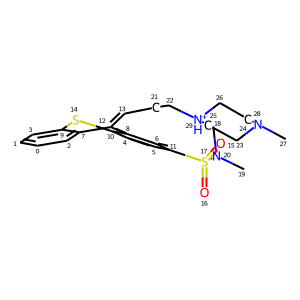

In [3]:
#### Testing: Helpers for file I/O ####

# create out folder if one does not already exist otherwise you run into errors.

pdb = load_pdb("protein_6a93.pdb")
print(f'Loaded PDB file with {len(pdb.atoms.residues)} residues and {len(pdb.atoms)} atoms.' + '\n')

supplier = load_sdf("ligands_5ht2a.sdf")
bad_count = 0
for mol in supplier:
    if mol is None:
        bad_count += 1
        
mols = [x for x in supplier]
print(mols[0])

print(f"Loaded SDF file containing {len(supplier)} molecules, {bad_count} incorrectly read." + "\n")

fname = "out/writeTest.sdf"
n = 10
write_supplier_subset(supplier, fname, range(n))

supplier = load_sdf(fname)

print(f"Saved SDF file has {len(supplier)} molecules.")

mols[0]

Future considerations:
 - Handling invalid filetypes
 - Handling invalid filepaths 
 - Handling writing to a file which already exists 
 - Handling of invalid structures 

In [4]:
### Helpers for filtering aspartate data ### 

def _mda_selection(universe: mda.Universe, selection: str) -> mda.Universe:
    
    ag = universe.select_atoms(selection)
    
    return mda.Merge(ag)


def select_asp_oxygens(universe: mda.Universe, asp_index: int) -> mda.Universe:
    """
    Given an MDAnalysis universe, selects the OD1 and OD2 oxygen atoms from a given aspartic acid 
    residue.
    
    Inputs:
        universe: mda.Universe
            The MDAnalysis Universe to be filtered.
        asp_index: int 
            The index of the ASP residue to select OD1 and OD2 from. 
    Outputs:
        universe: mda.Universe
            A new MDAnalysis Universe containing only two oxygen atoms. 
            
    """
    sel = "(resname ASP) and (resid {0}) and (name OD1 OD2)"
    oxygens = _mda_selection(universe, sel.format(asp_index + 1))
    
    return oxygens


def get_mda_coordinates(universe: mda.Universe) -> np.ndarray:
    """
    Given an MDAnalysis Universe, returns the coordinate data from the currently loaded 
    trajectory frame.
    
    Inputs:
        universe: mda.Universe
            The MDAnalysis Universe to extract coordinate data from. 
    Outputs:
        coordinates: np.ndarray
            The xyz positions of each atom in the MDAnalysis Universe.
            
    """
    return universe.atoms.positions

In [5]:
### Testing: Helpers for filtering aspartate data ###
    
pdb = load_pdb("protein_6a93.pdb")
oxygens = select_asp_oxygens(pdb, 154)

out1 = "Filtered {0} atoms:"
out2 = "    Atom {0}: {1}"

print(out1.format(len(oxygens.atoms)))
for i, o in enumerate(oxygens.atoms):
    print(out2.format(i, o))

positions = get_mda_coordinates(oxygens)

print("\nAtomic coordinates:")
print(positions)


Filtered 2 atoms:
    Atom 0: <Atom 1: OD1 of type O of resname ASP, resid 155 and segid A and altLoc >
    Atom 1: <Atom 2: OD2 of type O of resname ASP, resid 155 and segid A and altLoc >

Atomic coordinates:
[[16.103  3.516 61.899]
 [13.944  3.118 61.906]]


Future considerations:
 - Handling the selection returning no atoms. 
 - Handling the selection returning number of atoms != 2.
 - Handling PDB files with unusual atom names.
 - Handling the selection returning atoms which aren't oxygen. 
 - Do oxygen selection using SMARTS instead?

In [6]:
### Helpers for performing SMARTS queries on ligand data ### 

def _apply_expression(mol, SMARTS_expression: str) -> Tuple:
    patt = Chem.MolFromSmarts(SMARTS_expression)
    return mol.GetSubstructMatches(patt)


def _unpack_tuple(t: Tuple):
    ixs = set(itertools.chain(*t))
    
    return tuple(ixs)


def _get_atom_coords(conformer, ix):
    p = conformer.GetAtomPosition(ix)
    return np.array(p)


def SMARTS_filter(mol: Chem.Mol, smarts: str) -> Tuple[int]:
    """
    Given an RDKit Mol, find the indices of atoms which match a SMARTS expression. 
    
    Input:
        mol: Chem.Mol
            The RDKit Mol to apply the SMARTS expression to.
        smarts: str:
            A SMARTS expression.
    Returns:
        atom_ixs: Tuple[int]
            The indices of atoms in the Mol which match the SMARTS expression. 

    """
    atom_ixs = _apply_expression(mol, smarts)
    atom_ixs = _unpack_tuple(atom_ixs)
    
    return atom_ixs


def get_rdkit_coordinates(mol: Chem.Mol, atom_ixs: Tuple[int]) -> np.ndarray:
    """
    Given an RDKit Mol and a set of atom indices, returns a subset of the molecule coordinate 
    data.  
    
    Inputs:
        mol: Chem.Mol
            The RDKit Mol to extract coordinate data from. 
    Outputs:
        coordinates: np.ndarray
            The xyz positions each atom in the RDKit Mol with a matching index.
            
    """
    conformer = mol.GetConformer()
    positions = [_get_atom_coords(conformer, x) for x in atom_ixs]
    
    return np.asarray(positions)

In [7]:
### Testing: Helpers for performing SMARTS queries on ligand data ###
    
mol = Chem.MolFromSmiles("[NH3+]C1CCC(Nc2nc(NCc3ccccc3)c3ncn(C4CCCC4)c3n2)CC1")
Chem.rdCoordGen.AddCoords(mol)
out = "Selected {0} atoms from structure. Atom indices are {1}."

c = "[#7&!+]"
result = SMARTS_filter(mol, c)
result_str = ", ".join([str(x) for x in result])

print(out.format(len(result), result_str))

coordinates = get_rdkit_coordinates(mol, result)
print("Atomic coordinates: ")
print(coordinates)

Selected 6 atoms from structure. Atom indices are 5, 7, 9, 18, 20, 27.
Atomic coordinates: 
[[-1.74477338 -1.38676668  0.        ]
 [-0.01277334 -1.38336664  0.        ]
 [ 1.71922671 -1.37976664  0.        ]
 [ 1.59222666  0.78903326  0.        ]
 [ 0.18922665  1.59543325  0.        ]
 [-0.88177335  0.11503332  0.        ]]


Future considerations:
 - Handling no matches for the given SMARTS expression.
 - Handling invalid atom indices. 
 - Handling an RDKit Mol without any conformer data. 
 - Make MDAnalysis and RDKit coordinate retrieving functions consistent with one another. 

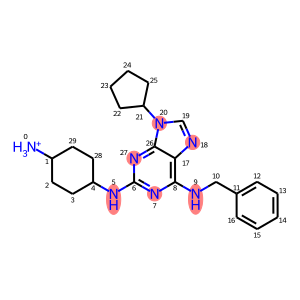

In [8]:
mol

In [9]:
### Helpers for distance computation ###

def calculate_distance_matrix(coords1: np.ndarray, coords2: np.ndarray) -> np.ndarray:
    """
    Given an numpy ndarray representing n atomic positions and another representing m, 
    compute the distance between each pair of positions between the two arrays. Will return
    an array of (n,m) shape.
    
    Inputs:
        coords1: np.ndarray
            The coordinates of the first set of atom positions. Can be shape (n,3) or (3,n).
        coords2: np.ndarray
            The coordinates of the second set of atom positions. Can be shape (m,3) or (3,m).
    Returns:
        distances: np.ndarray
            The distances between each pair of positions between the two arrays, shape (n,m).
    
    """
    return distances.distance_array(coords1, coords2)


def get_largest_below_threshold(distance_matrix: np.ndarray, threshold: float) -> float:
    """
    Given a numpy ndarray, get the largest contained value which is lower than a threshold value.
    If no value is below the threshold, returns inf. 
    
    Inputs:
        distance_matrix: np.ndarray
            An (m,n) array containing a set of computed distances. 
        threshold: float
            The threshold value to be used. 
    Returns:
        largest: float
            The largest value in the distance matrix below a given threshold.  

    """
    flattened = distance_matrix.flatten()
    below_threshold = flattened[flattened < threshold]
    
    if len(below_threshold) > 0:
        return below_threshold.max()
    else:
        return float("inf")

In [10]:
### Testing ###

coords1 = np.asarray([[0,0,0], [1,1,1]])
coords2 = np.asarray([[1,0,0],[0,1,0],[0,0,1]])

print("Computed distance matrix:")
print(calculate_distance_matrix(coords1, coords2))
print()

arr = np.asarray([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])

threshold = 6.5 
out = "Largest value below {0} is {1}."

longest = get_largest_below_threshold(arr, threshold)
print(out.format(threshold, longest) + "\n")

threshold = -10
out = "No value found below {0}."
longest = get_largest_below_threshold(arr, threshold)
if longest == float("inf"):
    print(out.format(threshold))

Computed distance matrix:
[[1.         1.         1.        ]
 [1.41421356 1.41421356 1.41421356]]

Largest value below 6.5 is 6.

No value found below -10.


In [11]:
# Helpers for editing SDF data 

def set_properties(mol: Chem.Mol, properties: Dict[str, str]):
    """
    Given a Chem.Mol file, set the name and value of a series of properties. 
    
    Inputs:
        mol: Chem.Mol
            RDKit Mol file to add properties to. 
        properties: Dict[str,str]
            A dictionary containing the property data. Both the keys and values should be given as strings.
    
    """
    for k, v in properties.items():
        mol.SetProp(k, v)

In [12]:
### Testing: Helpers for editing SDF data ###

mol = Chem.MolFromSmiles("[NH3+]C1CCC(Nc2nc(NCc3ccccc3)c3ncn(C4CCCC4)c3n2)CC1")
Chem.AllChem.EmbedMolecule(mol)

properties = {"property_name": "property_value"}
k = list(properties.keys())[0]

set_properties(mol, properties)

out = "Chem.Mol object has property with name '{0}' and value '{1}'."


if mol.HasProp(k):
    v = mol.GetProp(k) 
    print(out.format(k, v))
else:
    print("Property not found.")

fname = "out/propertyTest.sdf"
with Chem.SDWriter(fname) as w:
    w.write(mol)      
        
mol = Chem.SDMolSupplier(fname)[0]

if mol.HasProp(k):
    v = mol.GetProp(k) 
    print(out.format(k, v))
else:
    print("Property not found.")

Chem.Mol object has property with name 'property_name' and value 'property_value'.
Chem.Mol object has property with name 'property_name' and value 'property_value'.


[14:55:11] Molecule does not have explicit Hs. Consider calling AddHs()


Future considerations:
- Strictly enforce that the dictionary only has string values. 

In [13]:
### Filtering of molecules ###

def filter_mols(
    pdb_file: str, 
    input_ligand_sdf: str, 
    output_file_sdf: str, 
    asp_index: int, 
    salt_bridge_distance_cutoff: float = 3.5
    ):
    """
    Function to filter input ligands to only those poses that contain a salt bridge with 
    the conserved aspartate in the GPCR. Saves the filtered ligands to an SDF file.
    
    Inputs:
        pdb_file: str
            The PDB file of the protein to analyse.
            
        input_ligand_sdf: str
            The sdf file of the docked ligand poses to filter.
            
        output_file: str
            The sdf file to write the filtered ligands to.
            
        asp_index: int
            The residue index representing the conserved Aspartate. It is 155 for 5HT2A.
            
        salt_bridge_distance_cutoff: float
            Docked poses will be kept only if they have a salt bridge less than this specified value.
            
    Returns:
        None
    """
    
    pdb = load_pdb(pdb_file)
    oxygens = select_asp_oxygens(pdb, asp_index)
    o_xyz = get_mda_coordinates(oxygens)
    
    suppl = load_sdf(sdf_file)
    
    aliphatic_n = "$(N)"
    not_conjugated = "!$(A-A=A-A)" # This is not a great definition.
    not_aro_adjacent = "!$(*a)"
    
    expr = "[" + not_conjugated + "&" + not_aro_adjacent + "&" + aliphatic_n + "]"
    
    prop_name = "LONGEST D155-N DISTANCE"
    write_ixs = []
    
    for i, mol in enumerate(suppl):
        n_ixs = SMARTS_filter(mol, expr)
        
        if len(n_ixs) == 0:
            continue 

        n_xyz = get_rdkit_coordinates(mol, n_ixs)       
        no_distances = calculate_distance_matrix(o_xyz, n_xyz)
        longest_contact = get_largest_below_threshold(no_distances, salt_bridge_distance_cutoff)
        
        if longest_contact < salt_bridge_distance_cutoff:
            set_properties(mol, {prop_name: str(longest_contact)})
            write_ixs.append(i)
    
    if write_ixs:
        write_supplier_subset(suppl, output_file, write_ixs)

Filtered 176 molecules. Drawing random...
In molecule, atom(s) 19, 31 matches the SMARTS expression.
Calculated distance matrix: 
[[5.1634419  9.06302719]
 [3.34285748 7.62408673]]
Longest N-D155 contact is 3.3428574762006864 angstroms.


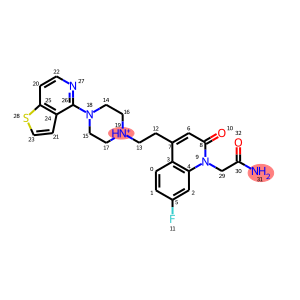

In [14]:
### Testing: Filtering of molecules ###

pdb_file = "protein_6a93.pdb"
sdf_file = "ligands_5ht2a.sdf"
output_file = "out/output.sdf"
asp_index = 154

filter_mols(pdb_file, sdf_file, output_file, asp_index)
supplr = Chem.SDMolSupplier("out/output.sdf")

total = len(supplr)
out = "Filtered {0} molecules. Drawing random..."
print(out.format(total))

import random

r = random.randint(0, total - 1)
mol = supplr[r]

aliphatic_n = "$(N)"
not_conjugated = "!$(A-A=A-A)"
not_aro_adjacent = "!$(*a)"
    
expr = "[" + not_conjugated + ";" + not_aro_adjacent + ";" + aliphatic_n + "]"

pdb = load_pdb(pdb_file)
oxygens = select_asp_oxygens(pdb, 154)
o_xyz = get_mda_coordinates(oxygens)

n_ixs = SMARTS_filter(mol, expr)
out = "In molecule, atom(s) {0} matches the SMARTS expression."
print(out.format(", ".join([str(x) for x in n_ixs])))

n_xyz = get_rdkit_coordinates(mol, n_ixs)
no_distances = calculate_distance_matrix(o_xyz, n_xyz)

print("Calculated distance matrix: ")
print(no_distances)

longest_contact = get_largest_below_threshold(no_distances, 3.5)

if longest_contact > 3.5:
    print("Too long contact detected.")
else:
    print("Longest N-D155 contact is " + str(longest_contact) + " angstroms.")

Chem.rdCoordGen.AddCoords(mol)
mol

Future considerations:
 - Could refactor to only use MDAnalysis 
   - Cons: Likely slower and less memory-efficient.
   - Pros: Code will be shorter, more readable, and easier to manage.
 - Could be more streamlined overall. 
 - Adding an SD tag works in isolation, but does not work as part of the main function. Not sure why.
 - Write formal unit tests. 
 - 'Not conjugated' is difficult to define programmatically.
     - Calculating pka is arguably more practical than estimating whether a lone pair is delocalized (but slower). 
     - Certain groups (e.g. amidine, guanidine) are conjugated, but still can form electrostatic bridges. 
     - My definition seems to work in this context, but I can think of use cases where it wouldn't. 

In [15]:
# my notes

In [16]:
>>> suppl = Chem.SDMolSupplier('data/5ht3ligs.sdf')
>>> for mol in suppl:
...   print(mol.GetNumAtoms())
    
# Two good practices when working with Suppliers are to use a context manager and to test each molecule 
# to see if it was correctly read before working with it:  
>>> with Chem.SDMolSupplier('data/5ht3ligs.sdf') as suppl:
...   for mol in suppl:
...     if mol is None: continue
    mols = [x for x in suppl]
    
>>> atom = m.GetAtomWithIdx(0)
>>> [x.GetAtomicNum() for x in atom.GetNeighbors()]


crn = Chem.MolFromPDBFile('../data/1CRN.pdb')
# get the residue information for each atom:
residues = [atom.GetPDBResidueInfo() for atom in crn.GetAtoms()]
# and now the number and name of each residue
resinf = [(res.GetResidueNumber(),res.GetResidueName()) for res in residues]
# take a look at those:
resinf[:10]
## this is a list of each residue and which amino acid it belongs to
# and get the ordered list of actual residues:
residues = sorted(set(resinf))
## this is a set of all amino acid present in the protein

## prints (atom) x y z coordinate
for molecule in mol_list:
    molecule = Chem.AddHs(molecule)
    print(molecule.GetNumAtoms())
    AllChem.EmbedMolecule(molecule)
    AllChem.UFFOptimizeMolecule(molecule)
    molecule.GetConformer()
    print()

    for i, atom in enumerate(molecule.GetAtoms()):
        positions = molecule.GetConformer().GetAtomPosition(i)
        print(atom.GetSymbol(), positions.x, positions.y, positions.z)
        
# how do you disclude all conjugated Ns? not just those in aromatic rings??

OSError: File error: Bad input file data/5ht3ligs.sdf

In [ ]:
asp = Chem.MolFromSmiles('C(C(C(=O)O)N)C(=O)O')
asp